[![Roboflow Notebooks](https://media.roboflow.com/notebooks/template/bannertest2-2.png?ik-sdk-version=javascript-1.4.3&updatedAt=1672932710194)](https://github.com/roboflow/notebooks)

# Segment Anything Model (SAM)

---

[![GitHub](https://badges.aleen42.com/src/github.svg)](https://github.com/facebookresearch/segment-anything) [![arXiv](https://img.shields.io/badge/arXiv-2304.02643-b31b1b.svg)](https://arxiv.org/abs/2304.02643)

Segment Anything Model (SAM): a new AI model from Meta AI that can "cut out" any object, in any image, with a single click. SAM is a promptable segmentation system with zero-shot generalization to unfamiliar objects and images, without the need for additional training. This notebook is an extension of the [official notebook](https://colab.research.google.com/github/facebookresearch/segment-anything/blob/main/notebooks/automatic_mask_generator_example.ipynb) prepared by Meta AI.

![segment anything model](https://media.roboflow.com/notebooks/examples/segment-anything-model-paper.png)

## Complementary Materials

---

[![Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/roboflow-ai/notebooks/blob/main/notebooks/how-to-segment-anything-with-sam.ipynb) [![YouTube](https://badges.aleen42.com/src/youtube.svg)](https://youtu.be/D-D6ZmadzPE) [![Roboflow](https://raw.githubusercontent.com/roboflow-ai/notebooks/main/assets/badges/roboflow-blogpost.svg)](https://blog.roboflow.com/how-to-use-segment-anything-model-sam)

We recommend that you follow along in this notebook while reading the blog post on Segment Anything Model.

![segment anything model blogpost](https://media.roboflow.com/notebooks/examples/segment-anything-model-blogpost.png)

## Pro Tip: Use GPU Acceleration

If you are running this notebook in Google Colab, navigate to `Edit` -> `Notebook settings` -> `Hardware accelerator`, set it to `GPU`, and then click `Save`. This will ensure your notebook uses a GPU, which will significantly speed up model training times.

## Steps in this Tutorial

In this tutorial, we are going to cover:

- **Before you start** - Make sure you have access to the GPU
- Install Segment Anything Model (SAM)
- Download Example Data
- Load Model
- Automated Mask Generation
- Generate Segmentation with Bounding Box
- Segment Anything in Roboflow Universe Dataset

## Let's begin!

## Before you start

Let's make sure that we have access to GPU. We can use `nvidia-smi` command to do that. In case of any problems navigate to `Edit` -> `Notebook settings` -> `Hardware accelerator`, set it to `GPU`, and then click `Save`.

In [4]:
!nvidia-smi

Wed Dec 20 14:57:21 2023       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  NVIDIA GeForce RTX 2080 Ti     Off | 00000000:01:00.0 Off |                  N/A |
|  0%   41C    P8               6W / 260W |    179MiB / 11264MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

**NOTE:** To make it easier for us to manage datasets, images and models we create a `HOME` constant.

In [5]:
import os
HOME = os.getcwd()
print("HOME:", HOME)

HOME: /home/centrox_ai


## Install Segment Anything Model (SAM) and other dependencies

In [6]:
!pip install -q 'git+https://github.com/facebookresearch/segment-anything.git'

In [7]:
!pip install -q jupyter_bbox_widget roboflow dataclasses-json supervision

### Download SAM weights

In [8]:
# !mkdir -p {HOME}/weights
# !wget -q https://dl.fbaipublicfiles.com/segment_anything/sam_vit_h_4b8939.pth -P {HOME}/weights

In [9]:
pip install torchvision

Note: you may need to restart the kernel to use updated packages.


In [10]:
import os

CHECKPOINT_PATH = os.path.join(HOME, "weights", "sam_vit_h_4b8939.pth")
print(CHECKPOINT_PATH, "; exist:", os.path.isfile(CHECKPOINT_PATH))

/home/centrox_ai/weights/sam_vit_h_4b8939.pth ; exist: True


## Download Example Data

**NONE:** Let's download few example images. Feel free to use your images or videos.

In [ ]:
!mkdir -p {HOME}/data

!wget -q https://media.roboflow.com/notebooks/examples/dog.jpeg -P {HOME}/data
!wget -q https://media.roboflow.com/notebooks/examples/dog-2.jpeg -P {HOME}/data
!wget -q https://media.roboflow.com/notebooks/examples/dog-3.jpeg -P {HOME}/data
!wget -q https://media.roboflow.com/notebooks/examples/dog-4.jpeg -P {HOME}/data

In [11]:
pip install torch

Note: you may need to restart the kernel to use updated packages.


## Load Model

In [48]:
import torch

DEVICE = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
MODEL_TYPE = "vit_h"

In [49]:
from segment_anything import sam_model_registry, SamAutomaticMaskGenerator, SamPredictor

sam = sam_model_registry[MODEL_TYPE](checkpoint=CHECKPOINT_PATH).to(device=DEVICE)

In [50]:
mask_generator = SamAutomaticMaskGenerator(sam)

In [51]:
import os

IMAGE_NAME = "m4.png"
IMAGE_PATH = os.path.join(HOME, "data", IMAGE_NAME)

In [52]:
import cv2
import supervision as sv

image_bgr = cv2.imread(IMAGE_PATH)
image_rgb = cv2.cvtColor(image_bgr, cv2.COLOR_BGR2RGB)

sam_result = mask_generator.generate(image_rgb)

In [53]:
print(sam_result[0].keys())

dict_keys(['segmentation', 'area', 'bbox', 'predicted_iou', 'point_coords', 'stability_score', 'crop_box'])


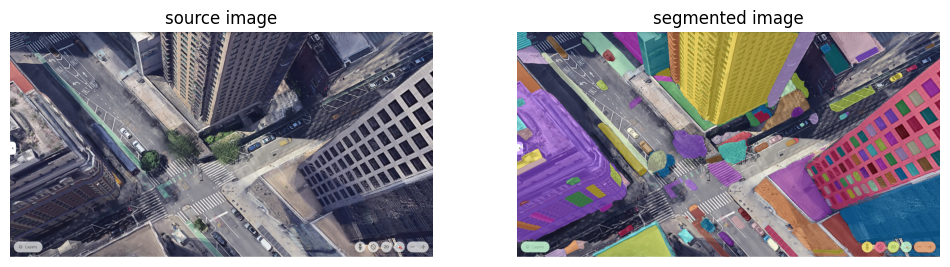

In [54]:
mask_annotator = sv.MaskAnnotator(color_lookup=sv.ColorLookup.INDEX)

detections = sv.Detections.from_sam(sam_result=sam_result)

annotated_image = mask_annotator.annotate(scene=image_bgr.copy(), detections=detections)

sv.plot_images_grid(
    images=[image_bgr, annotated_image],
    grid_size=(1, 2),
    titles=['source image', 'segmented image']
)

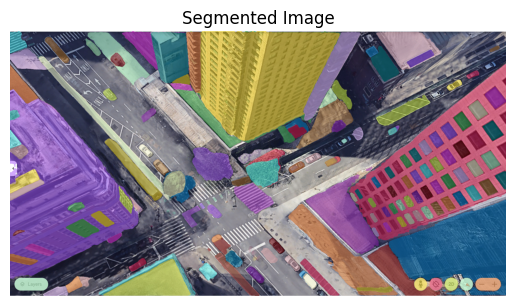

In [55]:
import matplotlib.pyplot as plt

# Assuming annotated_image is the annotated output image
plt.imshow(cv2.cvtColor(annotated_image, cv2.COLOR_BGR2RGB))
plt.axis('off')
plt.title('Segmented Image')
plt.show()


## Automated Mask Generation

To run automatic mask generation, provide a SAM model to the `SamAutomaticMaskGenerator` class. Set the path below to the SAM checkpoint. Running on CUDA and with the default model is recommended.

### Output format

`SamAutomaticMaskGenerator` returns a `list` of masks, where each mask is a `dict` containing various information about the mask:

* `segmentation` - `[np.ndarray]` - the mask with `(W, H)` shape, and `bool` type
* `area` - `[int]` - the area of the mask in pixels
* `bbox` - `[List[int]]` - the boundary box of the mask in `xywh` format
* `predicted_iou` - `[float]` - the model's own prediction for the quality of the mask
* `point_coords` - `[List[List[float]]]` - the sampled input point that generated this mask
* `stability_score` - `[float]` - an additional measure of mask quality
* `crop_box` - `List[int]` - the crop of the image used to generate this mask in `xywh` format

### Interaction with segmentation results

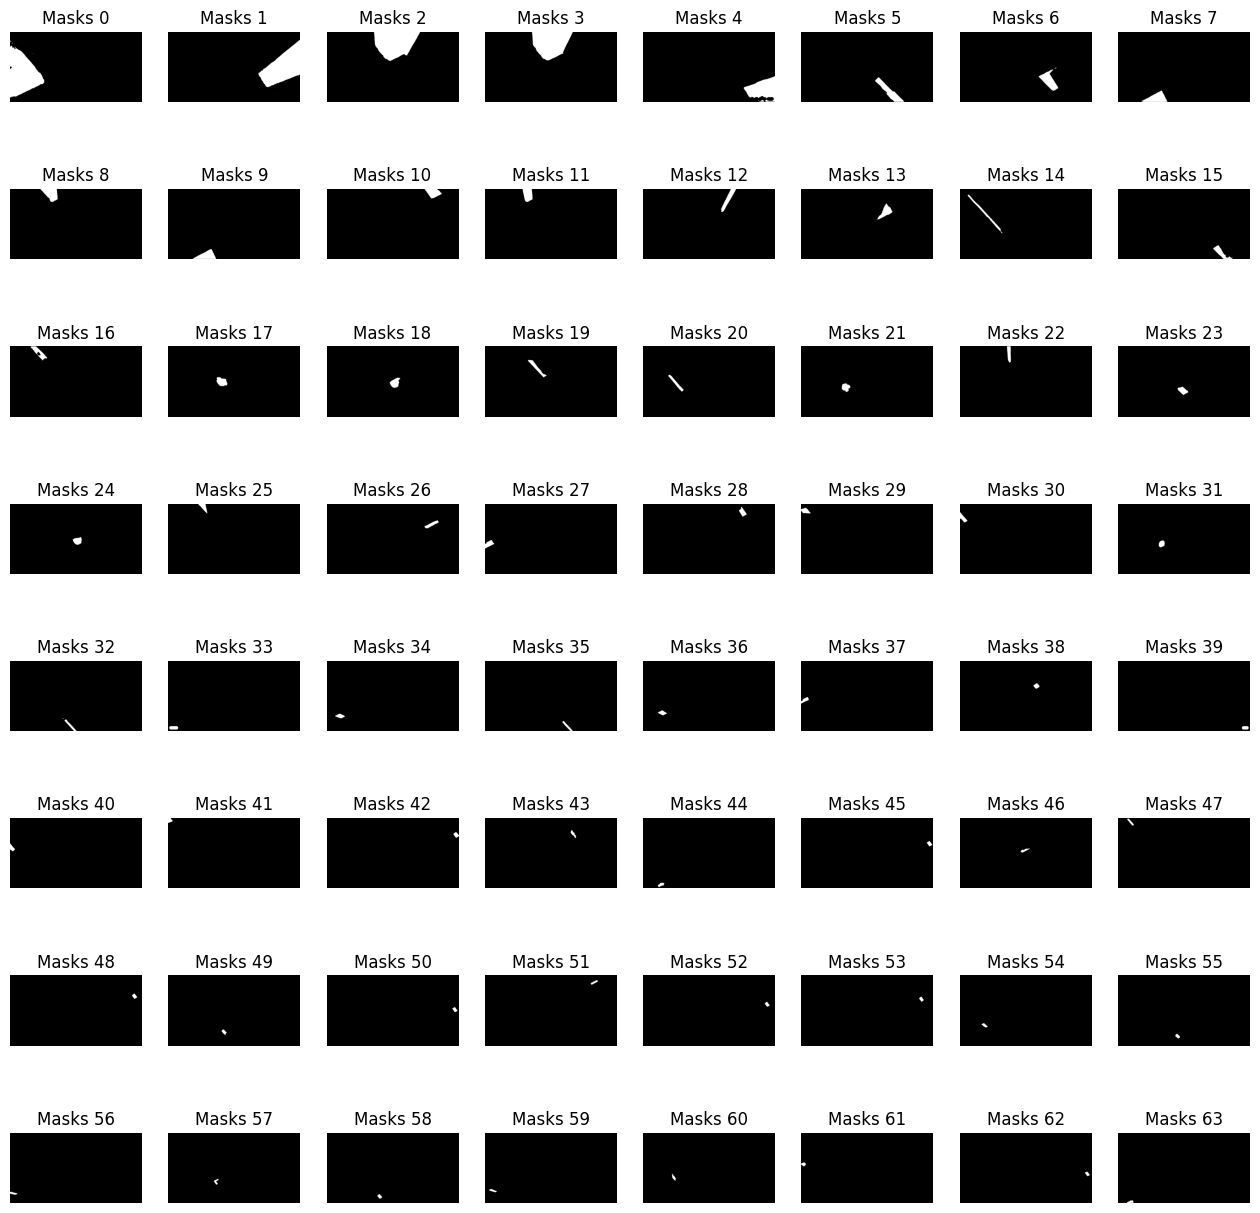

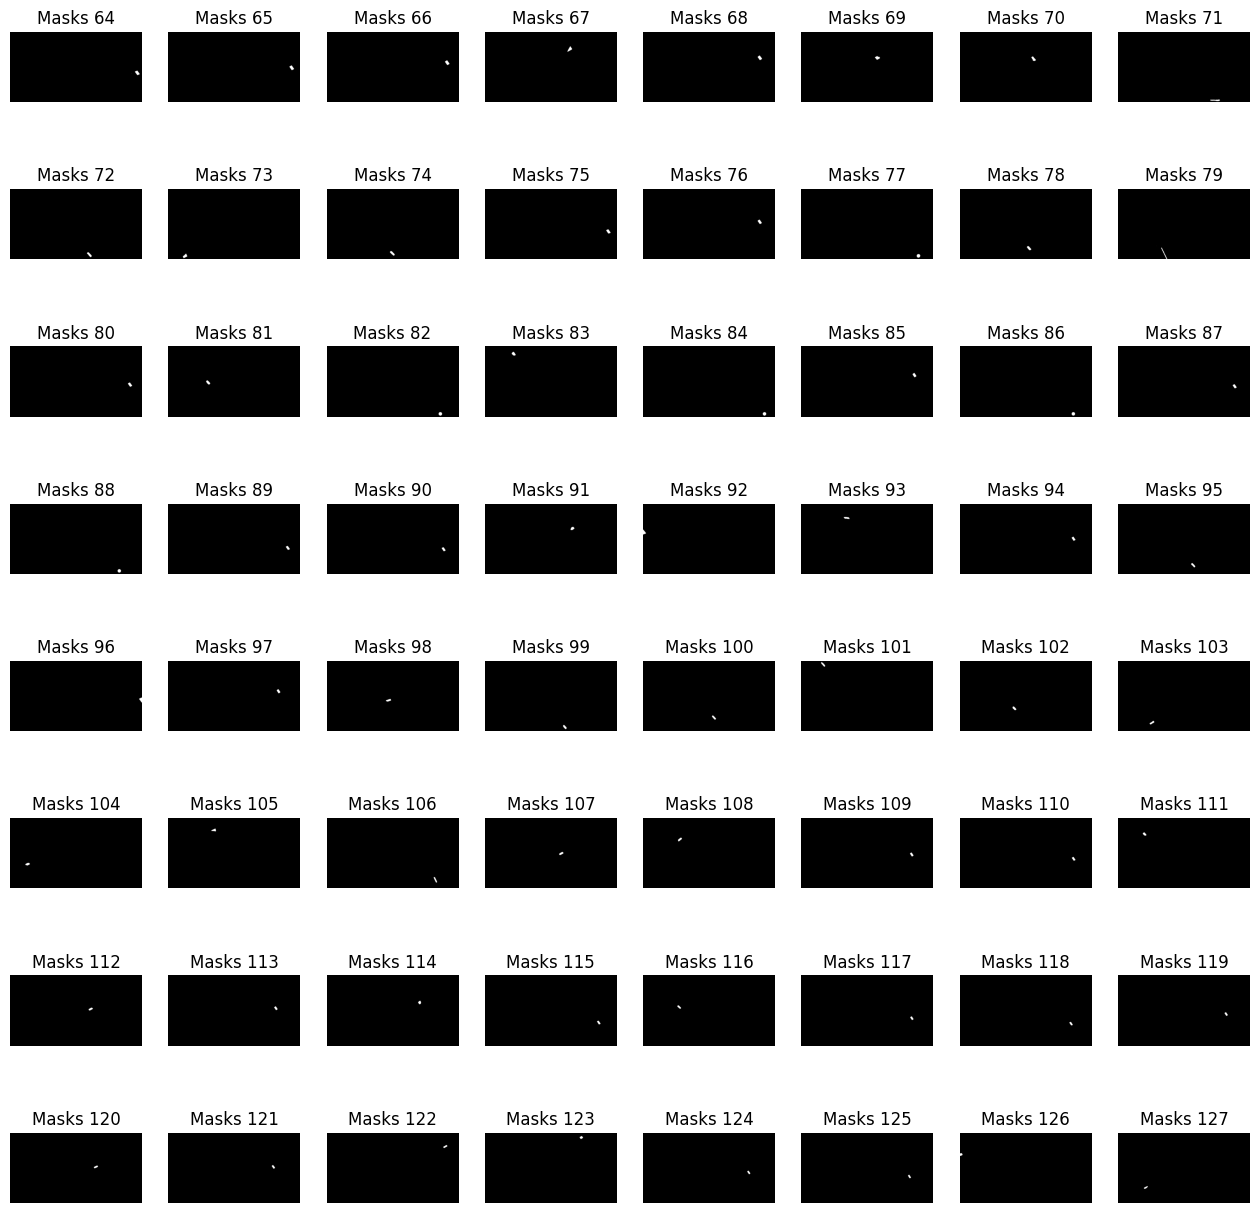

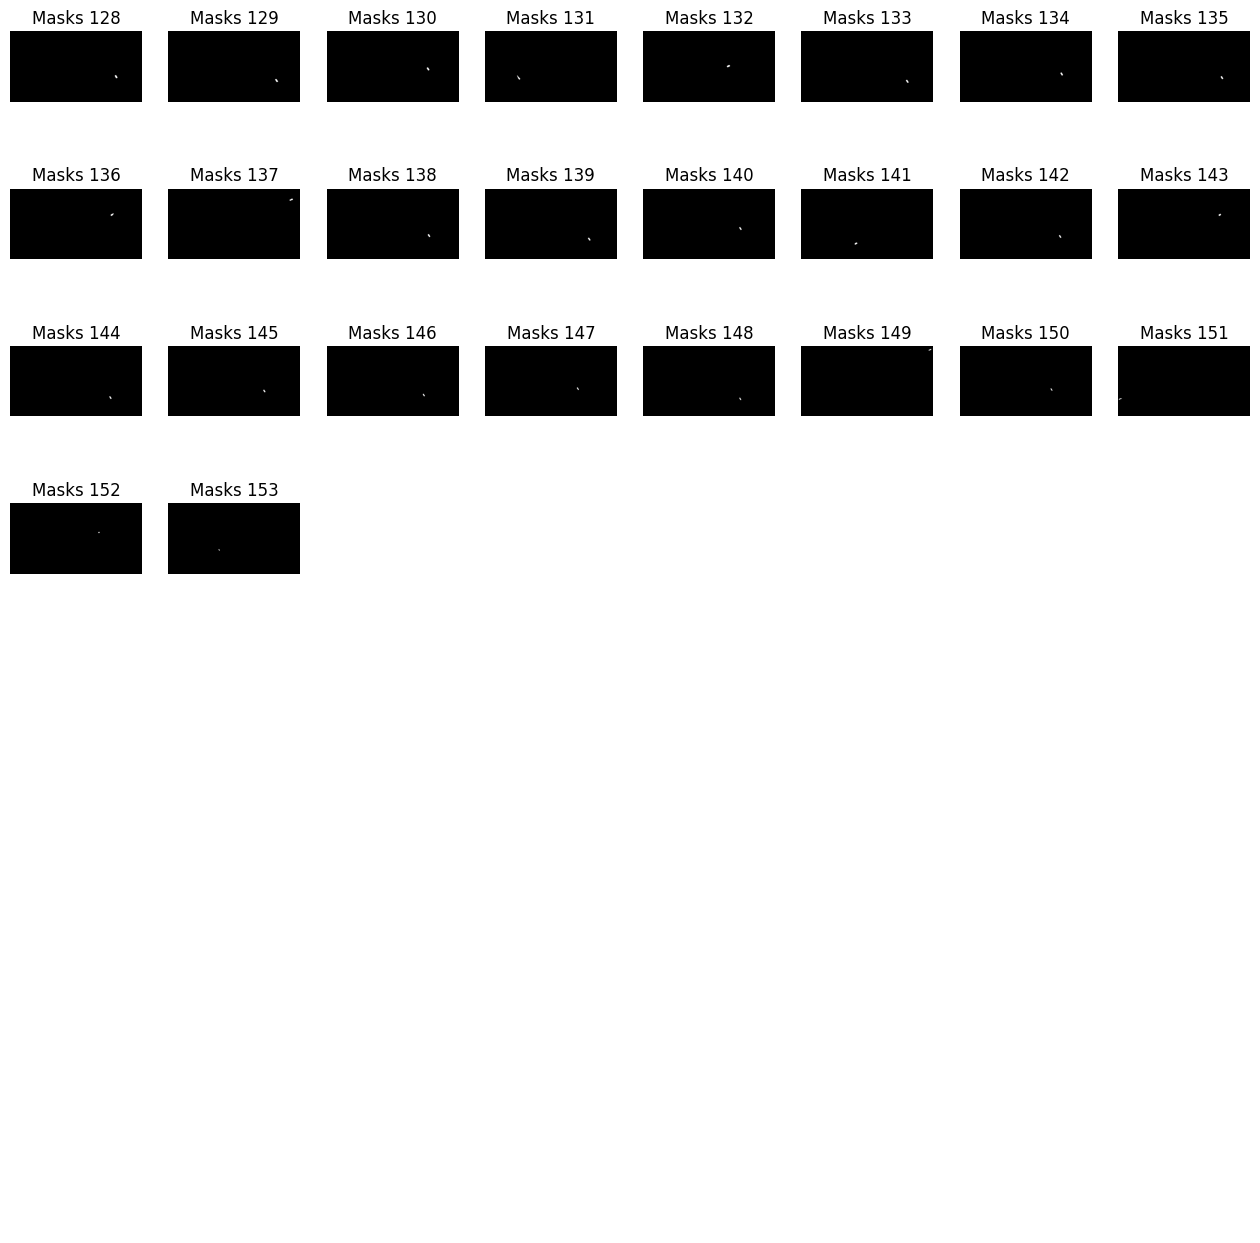

In [56]:
masks = [
    mask['segmentation']
    for mask
    in sorted(sam_result, key=lambda x: x['area'], reverse=True)
]
# Split the masks into groups of size 8x8 for pagination
mask_groups = [masks[i:i + 64] for i in range(0, len(masks), 64)]

# Plot each group of masks separately
for idx, group in enumerate(mask_groups):
    sv.plot_images_grid(
        images=group,
        grid_size=(8, 8),
        size=(16, 16),
        titles=[f'Masks {idx * 64 + i}' for i in range(len(group))]
    )


In [57]:
import numpy as np

# Assuming you have masks for cars, buildings, trees, etc. in the 'masks' array
# masks = [car_mask, building_mask, tree_mask, ...]

# Combine masks for cars, buildings, trees, etc. into a single composite mask
composite_mask = np.zeros_like(masks[0], dtype=bool)
for mask in masks:
    composite_mask |= mask  # Combine masks using logical OR operation

# Invert the composite mask to get the areas where the masks are not present
background_mask = ~composite_mask

# Apply the background mask to the segmented image to remove masks
modified_image = annotated_image.copy()  # Make a copy of the segmented image
background_color = [0, 0, 0]  # Define the background color or values

# Replace pixels corresponding to the masks with the background color
modified_image[composite_mask] = background_color

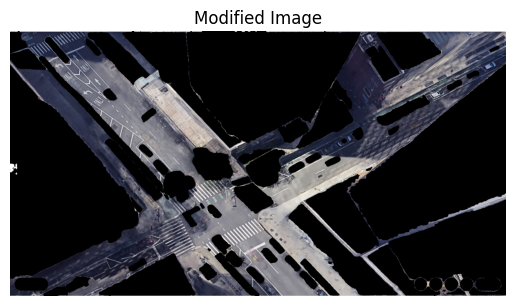

In [58]:
import matplotlib.pyplot as plt

# Display the modified image using Matplotlib
plt.imshow(cv2.cvtColor(modified_image, cv2.COLOR_BGR2RGB))
plt.axis('off')  # Turn off axis labels
plt.title('Modified Image')  # Set the title
plt.show()  # Show the image


In [59]:
import numpy as np

# Assuming you have masks for cars, buildings, trees, etc. in the 'masks' array
# masks = [car_mask, building_mask, tree_mask, ...]

# Combine masks for cars, buildings, trees, etc. into a single composite mask
composite_mask = np.zeros_like(masks[0], dtype=bool)
for mask in masks:
    composite_mask |= mask  # Combine masks using logical OR operation

# Invert the composite mask to get the areas where the masks are not present
background_mask = ~composite_mask

# Apply the background mask to the segmented image to remove masks
modified_image = annotated_image.copy()  # Make a copy of the segmented image
background_color = [0, 0, 0]  # Define the background color or values
non_masked_color = [128, 0, 128]  # Define the color for non-masked areas (purple)

# Replace pixels corresponding to the masks with the background color
modified_image[composite_mask] = background_color

# Replace pixels corresponding to the non-masked areas with the non-masked color
modified_image[background_mask] = non_masked_color


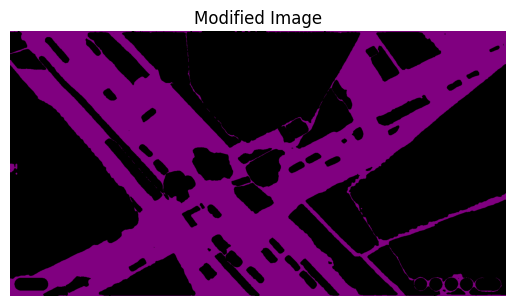

In [60]:
import matplotlib.pyplot as plt

# Display the modified image using Matplotlib
plt.imshow(cv2.cvtColor(modified_image, cv2.COLOR_BGR2RGB))
plt.axis('off')  # Turn off axis labels
plt.title('Modified Image')  # Set the title
plt.show()  # Show the image


In [ ]:
# import cv2

# # Specify the complete file path including the directory to save the annotated image
# output_directory = '/home/centrox_ai/data/'
# output_filename = 'a2.png'
# output_path = os.path.join(output_directory, output_filename)

# # Save the annotated image
# cv2.imwrite(output_path, annotated_image)
# print(f"Annotated image saved at {output_path}")


In [ ]:
# masks = [
#     mask['segmentation']
#     for mask
#     in sorted(sam_result, key=lambda x: x['area'], reverse=True)
# ]

# sv.plot_images_grid(
#     images=masks,
#     grid_size=(8, int(len(masks) / 8)),
#     size=(16, 16)
# )
######################################################################################

# Split the masks into groups of size 8x8 for pagination
# Plot all masks without grouping
# sv.plot_images_grid(
#     images=masks,
#     grid_size=(8, 13),  # Adjust grid size based on the total number of masks
#     size=(16, 16),
#     titles=[f'Mask {i}' for i in range(len(masks))]
# )

#Extracting the segmentations from sam_result


##############################################


# masks = [
#     mask['segmentation']
#     for mask
#     in sorted(sam_result, key=lambda x: x['area'], reverse=True)
# ][:100]  # Selecting the first 100 masks

# # Displaying the first 100 masks in a grid
# sv.plot_images_grid(
#     images=masks,
#     grid_size=(8, 13),  # Adjust grid size according to the number of masks
#     size=(16, 16)
# )


In [ ]:
#for video
# import cv2
# from matplotlib import pyplot as plt
# import os
# import supervision as sv

# # Function to perform segmentation
# def perform_segmentation(frame):
#     # Use your mask_generator, sam_result, and annotator logic here
#     sam_result = mask_generator.generate(frame)
#     detections = sv.Detections.from_sam(sam_result=sam_result)
#     segmented_frame = mask_annotator.annotate(scene=frame.copy(), detections=detections)
#     return segmented_frame

# # Open the video file
# video_capture = cv2.VideoCapture('data/newv.mp4')

# # Initialize video writer for output
# output_file = 'output_segmented_video.mp4'
# fps = int(video_capture.get(cv2.CAP_PROP_FPS))
# width = int(video_capture.get(cv2.CAP_PROP_FRAME_WIDTH))
# height = int(video_capture.get(cv2.CAP_PROP_FRAME_HEIGHT))
# video_writer = cv2.VideoWriter(output_file, cv2.VideoWriter_fourcc(*'mp4v'), fps, (width, height))

# # Loop through each frame of the video
# while True:
#     ret, frame = video_capture.read()

#     if not ret:
#         break

#     # Perform segmentation on 'frame'
#     segmented_frame = perform_segmentation(frame)

#     # Display segmented frame using Matplotlib
#     plt.imshow(cv2.cvtColor(segmented_frame, cv2.COLOR_BGR2RGB))
#     plt.axis('off')  # Hide axes
#     plt.show()

#     # Write segmented frame to output video
#     video_writer.write(segmented_frame)

# # Release resources
# video_capture.release()
# video_writer.release()


In [162]:
import cv2
import numpy as np

# Assuming you have masks for cars, buildings, and trees in the 'masks' array
# masks = [car_mask, building_mask, tree_mask, ...]

# Combine masks for cars, buildings, and trees into a single composite mask
composite_mask = np.zeros_like(masks[0], dtype=bool)
for mask in masks:
    composite_mask |= mask  # Combine masks using logical OR operation

# Ensure that the composite mask has the same dimensions as the image
composite_mask = cv2.resize(composite_mask.astype(np.uint8), (modified_width, modified_height), interpolation=cv2.INTER_NEAREST)
composite_mask = composite_mask.astype(bool)

# Invert the composite mask to get the areas where cars, buildings, and trees are not present
background_mask = ~composite_mask

# Apply the background mask to the segmented image to remove cars, buildings, and trees
modified_image = annotated_image.copy()  # Make a copy of the segmented image
background_color = [0, 0, 0]  # Define the background


In [215]:
import numpy as np

# Assuming you have masks for cars, buildings, trees, etc. in the 'masks' array
# masks = [car_mask, building_mask, tree_mask, ...]

# Combine masks for cars, buildings, trees, etc. into a single composite mask
composite_mask = np.zeros_like(masks[0], dtype=bool)
for mask in masks:
    composite_mask |= mask  # Combine masks using logical OR operation

# Invert the composite mask to get the areas where the masks are not present
background_mask = ~composite_mask

# Apply the background mask to the segmented image to remove masks
modified_image = annotated_image.copy()  # Make a copy of the segmented image
background_color = [0, 0, 0]  # Define the background color or values

# Replace pixels corresponding to the masks with the background color
modified_image[composite_mask] = background_color
# import cv2
# import numpy as np

# Assuming you have masks for cars, buildings, and trees in the 'masks' array
# masks = [car_mask, building_mask, tree_mask, ...]

# Combine masks for cars, buildings, and trees into a single composite mask
# import cv2
# import numpy as np

# # Assuming 'annotated_image' is the image and 'composite_mask' is the mask

# # Resize the composite mask to match the dimensions of the modified image
# modified_image_height, modified_image_width = modified_image.shape[:2]
# resized_mask = cv2.resize(composite_mask, (modified_image_width, modified_image_height), interpolation=cv2.INTER_NEAREST)

# # Apply the resized mask to the modified image
# background_color = [0, 0, 0]  # Define the background color or values
# modified_image[resized_mask != 0] = background_color


IndexError: boolean index did not match indexed array along dimension 0; dimension is 770 but corresponding boolean dimension is 776

In [201]:
import cv2
import numpy as np

# Assuming composite_mask has a shape (771, 1555)
# Reshape the mask to have an additional dimension for channels
composite_mask = composite_mask[:, :, np.newaxis]

# Repeat the mask across channels to match the shape of the annotated image
composite_mask = np.repeat(composite_mask, 3, axis=2)

# Check the shape
print("Annotated image shape:", annotated_image.shape)
print("Resized Composite mask shape:", composite_mask.shape)


Annotated image shape: (771, 1555, 3)
Resized Composite mask shape: (771, 1555, 3)


In [206]:
import cv2
import numpy as np

# Assuming you have masks for cars, buildings, and trees in the 'masks' array
# masks = [car_mask, building_mask, tree_mask, ...]

# Combine masks for cars, buildings, and trees into a single composite mask




composite_mask = np.zeros_like(masks[0], dtype=bool)
for mask in masks:
    composite_mask |= mask  # Combine masks using logical OR operation

# Ensure that the composite mask has the same dimensions as the image
composite_mask = cv2.resize(composite_mask.astype(np.uint8), (modified_image.shape[1], modified_image.shape[0]), interpolation=cv2.INTER_NEAREST)
composite_mask = composite_mask.astype(bool)

# Invert the composite mask to get the areas where cars, buildings, and trees are not present
background_mask = ~composite_mask

# Apply the background mask to the segmented image to remove cars, buildings, and trees
modified_image = annotated_image.copy()  # Make a copy of the segmented image
background_color = [0, 0, 0]  # Define the background color or values

# Replace pixels corresponding to the masks with the background color
modified_image[composite_mask] = background_color
composite_mask = composite_mask[:, :, np.newaxis]

# Repeat the mask across channels to match the shape of the annotated image
composite_mask = np.repeat(composite_mask, 3, axis=2)

# Check the shape
print("Annotated image shape:", annotated_image.shape)
print("Resized Composite mask shape:", composite_mask.shape)


Annotated image shape: (771, 1555, 3)
Resized Composite mask shape: (771, 1555, 3)


In [207]:
print("Annotated image shape:", annotated_image.shape)
print("Resized Composite mask shape:", composite_mask.shape)

Annotated image shape: (771, 1555, 3)
Resized Composite mask shape: (771, 1555, 3)


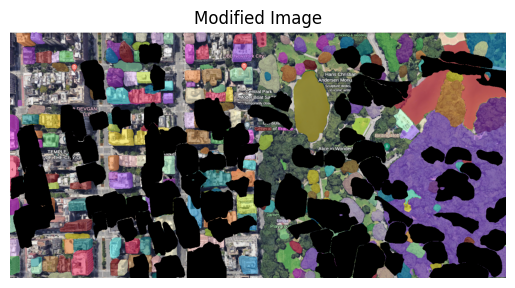

In [208]:
import matplotlib.pyplot as plt

# Display the modified image using Matplotlib
plt.imshow(cv2.cvtColor(modified_image, cv2.COLOR_BGR2RGB))
plt.axis('off')  # Turn off axis labels
plt.title('Modified Image')  # Set the title
plt.show()  # Show the image


In [161]:
import numpy as np

# Assuming you have masks for cars, buildings, and trees in the 'masks' array
# masks = [car_mask, building_mask, tree_mask, ...]

# Combine masks for cars, buildings, and trees into a single composite mask
composite_mask = np.zeros_like(masks[0], dtype=bool)
for mask in masks:
    composite_mask |= mask  # Combine masks using logical OR operation

# Invert the composite mask to get the areas where cars, buildings, and trees are not present
background_mask = ~composite_mask

# Apply the background mask to the segmented image to remove cars, buildings, and trees
modified_image = annotated_image.copy()  # Make a copy of the segmented image
background_color = [0, 0, 0]  # Define the background color or values

# Replace pixels corresponding to cars, buildings, and trees with the background color
modified_image[composite_mask] = background_color


IndexError: boolean index did not match indexed array along dimension 0; dimension is 771 but corresponding boolean dimension is 776

In [106]:
# import numpy as np

# # Broadcast the 2D mask to match the depth of the 3D image
# composite_mask_broadcasted = np.repeat(composite_mask[:, :, np.newaxis], 3, axis=2)

# # Apply the modified mask to remove the elements from the annotated image
# modified_image = annotated_image.copy()
# background_color = [0, 0, 0]  # Define the background color or values

# # Replace pixels corresponding to cars, buildings, and trees with the background color
# modified_image[composite_mask_broadcasted] = background_color


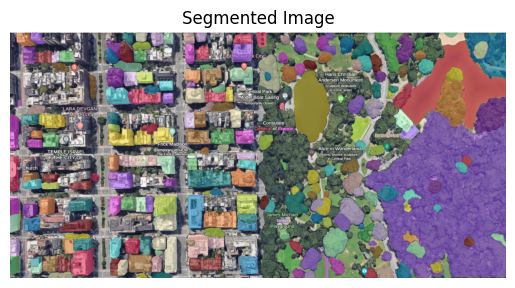

In [163]:
import matplotlib.pyplot as plt

# Assuming annotated_image is the annotated output image
plt.imshow(cv2.cvtColor(modified_image, cv2.COLOR_BGR2RGB))
plt.axis('off')
plt.title('Segmented Image')
plt.show()


In [158]:
print("Annotated image shape:", annotated_image.shape)
print("Composite mask shape:", modified_image.shape)


Annotated image shape: (771, 1555, 3)
Composite mask shape: (771, 1555, 3)


In [79]:
import cv2

# Specify the complete file path including the directory to save the annotated image
output_directory = '/home/centrox_ai/data/'
output_filename = 'a1.1.png'
output_path = os.path.join(output_directory, output_filename)

# Save the annotated image
cv2.imwrite(output_path, modified_image)
print(f"Annotated image saved at {output_path}")


Annotated image saved at /home/centrox_ai/data/a1.1.png


## Generate Segmentation with Bounding Box

The `SamPredictor` class provides an easy interface to the model for prompting the model. It allows the user to first set an image using the `set_image` method, which calculates the necessary image embeddings. Then, prompts can be provided via the `predict` method to efficiently predict masks from those prompts. The model can take as input both point and box prompts, as well as masks from the previous iteration of prediction.

In [33]:
mask_predictor = SamPredictor(sam)

In [34]:
import os

IMAGE_NAME = "m3.png"
IMAGE_PATH = os.path.join(HOME, "data", IMAGE_NAME)

### Draw Box



In [35]:
# helper function that loads an image before adding it to the widget

import base64

def encode_image(filepath):
    with open(filepath, 'rb') as f:
        image_bytes = f.read()
    encoded = str(base64.b64encode(image_bytes), 'utf-8')
    return "data:image/jpg;base64,"+encoded

**NOTE:** Execute cell below and use your mouse to draw bounding box on the image 👇

In [41]:
# IS_COLAB = False

# if IS_COLAB:
#     from google.colab import output
#     output.enable_custom_widget_manager()

# from jupyter_bbox_widget import BBoxWidget

# widget = BBoxWidget()
# widget.image = encode_image(IMAGE_PATH)
# widget


In [45]:
import tkinter as tk
from PIL import Image, ImageTk

class BoundingBoxDrawer:
    def __init__(self, master, image):
        self.master = master
        self.image = image
        self.canvas = tk.Canvas(master, width=image.width(), height=image.height())
        self.canvas.pack()
        self.canvas.create_image(0, 0, anchor=tk.NW, image=image)
        self.canvas.bind("<Button-1>", self.on_click)
        self.start_x, self.start_y = None, None
        self.rect = None

    def on_click(self, event):
        if self.start_x is None and self.start_y is None:
            self.start_x, self.start_y = event.x, event.y
        else:
            end_x, end_y = event.x, event.y
            self.draw_box(self.start_x, self.start_y, end_x, end_y)
            self.start_x, self.start_y = None, None

    def draw_box(self, x0, y0, x1, y1):
        if self.rect:
            self.canvas.delete(self.rect)
        self.rect = self.canvas.create_rectangle(x0, y0, x1, y1, outline="red")

# Replace 'path_to_your_image.jpg' with the path to your image file
image_path = 'data/m3.png'
image = Image.open(image_path)
root = tk.Tk()
root.title("Bounding Box Drawer")
bb_drawer = BoundingBoxDrawer(root, ImageTk.PhotoImage(image))
root.mainloop()


TclError: no display name and no $DISPLAY environment variable

In [20]:
widget.bboxes

[{'x': 77, 'y': 177, 'width': 530, 'height': 843, 'label': ''}]

### Generate masks with SAM

**NOTE:** `SamPredictor.predict` method takes `np.ndarray` `box` argument in `[x_min, y_min, x_max, y_max]` format. Let's reorganise your data first

In [21]:
import numpy as np

# default_box is going to be used if you will not draw any box on image above
default_box = {'x': 68, 'y': 247, 'width': 555, 'height': 678, 'label': ''}

box = widget.bboxes[0] if widget.bboxes else default_box
box = np.array([
    box['x'],
    box['y'],
    box['x'] + box['width'],
    box['y'] + box['height']
])

In [22]:
import cv2
import numpy as np
import supervision as sv

image_bgr = cv2.imread(IMAGE_PATH)
image_rgb = cv2.cvtColor(image_bgr, cv2.COLOR_BGR2RGB)

mask_predictor.set_image(image_rgb)

masks, scores, logits = mask_predictor.predict(
    box=box,
    multimask_output=True
)

### Results visualisation with Supervision

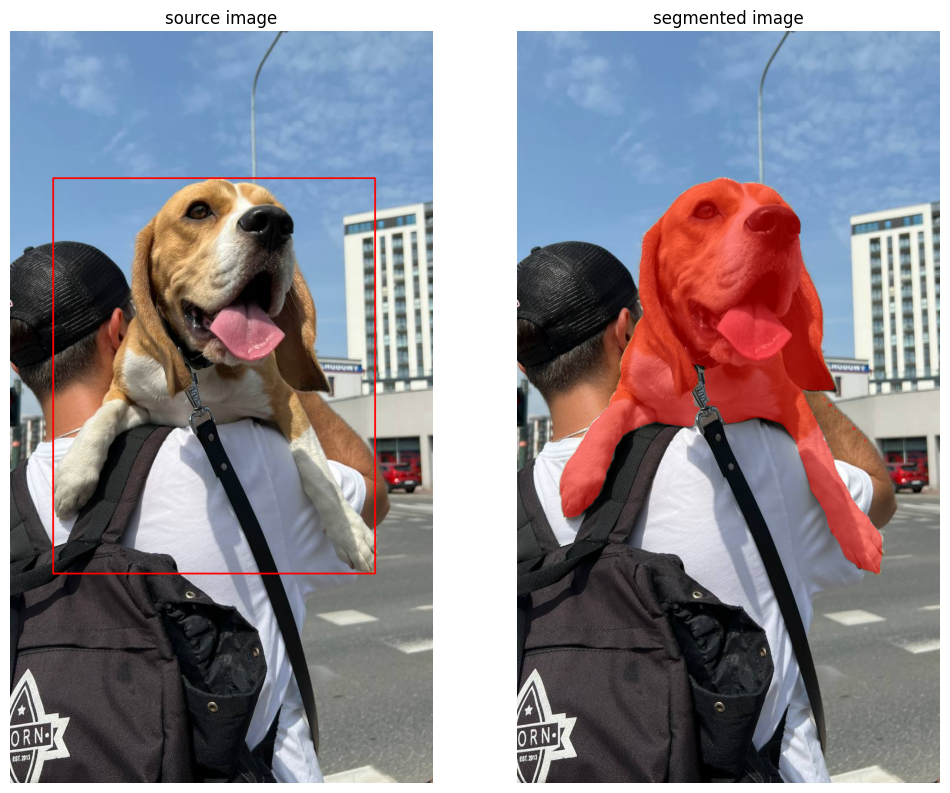

In [23]:
box_annotator = sv.BoxAnnotator(color=sv.Color.red())
mask_annotator = sv.MaskAnnotator(color=sv.Color.red(), color_lookup=sv.ColorLookup.INDEX)

detections = sv.Detections(
    xyxy=sv.mask_to_xyxy(masks=masks),
    mask=masks
)
detections = detections[detections.area == np.max(detections.area)]

source_image = box_annotator.annotate(scene=image_bgr.copy(), detections=detections, skip_label=True)
segmented_image = mask_annotator.annotate(scene=image_bgr.copy(), detections=detections)

sv.plot_images_grid(
    images=[source_image, segmented_image],
    grid_size=(1, 2),
    titles=['source image', 'segmented image']
)

### Interaction with segmentation results

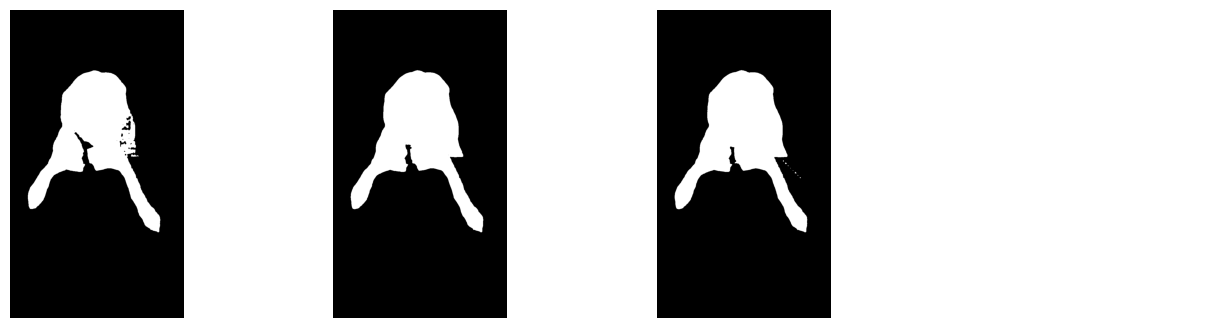

In [24]:
import supervision as v

sv.plot_images_grid(
    images=masks,
    grid_size=(1, 4),
    size=(16, 4)
)

## Segment Anything in Roboflow Universe Dataset

### Utils Supporting Dataset Processing

A couple of helper functions that, unfortunately, we have to write ourselves to facilitate the processing of COCO annotations.

In [25]:
import numpy as np
from dataclasses import dataclass
from typing import List, Tuple, Union, Optional
from dataclasses_json import dataclass_json
from supervision import Detections


@dataclass_json
@dataclass
class COCOCategory:
    id: int
    name: str
    supercategory: str


@dataclass_json
@dataclass
class COCOImage:
    id: int
    width: int
    height: int
    file_name: str
    license: int
    date_captured: str
    coco_url: Optional[str] = None
    flickr_url: Optional[str] = None


@dataclass_json
@dataclass
class COCOAnnotation:
    id: int
    image_id: int
    category_id: int
    segmentation: List[List[float]]
    area: float
    bbox: Tuple[float, float, float, float]
    iscrowd: int


@dataclass_json
@dataclass
class COCOLicense:
    id: int
    name: str
    url: str


@dataclass_json
@dataclass
class COCOJson:
    images: List[COCOImage]
    annotations: List[COCOAnnotation]
    categories: List[COCOCategory]
    licenses: List[COCOLicense]


def load_coco_json(json_file: str) -> COCOJson:
    import json

    with open(json_file, "r") as f:
        json_data = json.load(f)

    return COCOJson.from_dict(json_data)


class COCOJsonUtility:
    @staticmethod
    def get_annotations_by_image_id(coco_data: COCOJson, image_id: int) -> List[COCOAnnotation]:
        return [annotation for annotation in coco_data.annotations if annotation.image_id == image_id]

    @staticmethod
    def get_annotations_by_image_path(coco_data: COCOJson, image_path: str) -> Optional[List[COCOAnnotation]]:
        image = COCOJsonUtility.get_image_by_path(coco_data, image_path)
        if image:
            return COCOJsonUtility.get_annotations_by_image_id(coco_data, image.id)
        else:
            return None

    @staticmethod
    def get_image_by_path(coco_data: COCOJson, image_path: str) -> Optional[COCOImage]:
        for image in coco_data.images:
            if image.file_name == image_path:
                return image
        return None

    @staticmethod
    def annotations2detections(annotations: List[COCOAnnotation]) -> Detections:
        class_id, xyxy = [], []

        for annotation in annotations:
            x_min, y_min, width, height = annotation.bbox
            class_id.append(annotation.category_id)
            xyxy.append([
                x_min,
                y_min,
                x_min + width,
                y_min + height
            ])

        return Detections(
            xyxy=np.array(xyxy, dtype=int),
            class_id=np.array(class_id, dtype=int)
        )

### Download Dataset from Roboflow

In [29]:
%cd {HOME}

import roboflow
from roboflow import Roboflow

roboflow.login()

rf = Roboflow()

project = rf.workspace("hashira-fhxpj").project("mri-brain-tumor")
dataset = project.version(1).download("coco")

/content
visit https://app.roboflow.com/auth-cli to get your authentication token.
Paste the authentication token here: ··········


ValueError: ignored

In [ ]:
import os

DATA_SET_SUBDIRECTORY = "test"
ANNOTATIONS_FILE_NAME = "_annotations.coco.json"
IMAGES_DIRECTORY_PATH = os.path.join(dataset.location, DATA_SET_SUBDIRECTORY)
ANNOTATIONS_FILE_PATH = os.path.join(dataset.location, DATA_SET_SUBDIRECTORY, ANNOTATIONS_FILE_NAME)

In [ ]:
coco_data = load_coco_json(json_file=ANNOTATIONS_FILE_PATH)

CLASSES = [
    category.name
    for category
    in coco_data.categories
    if category.supercategory != 'none'
]

IMAGES = [
    image.file_name
    for image
    in coco_data.images
]

In [ ]:
CLASSES

['YES-TUMOR']

### Single Image Bounding Box to Mask

In [ ]:
# set random seed to allow easy reproduction of the experiment

import random
random.seed(10)

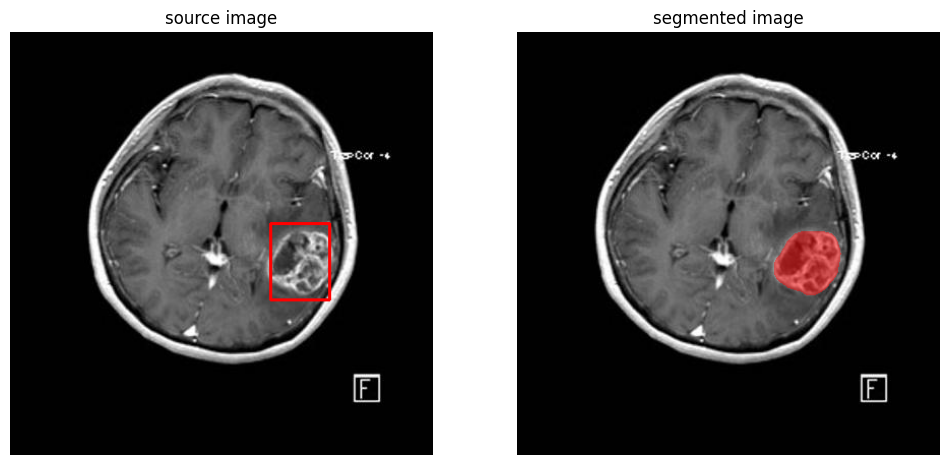

In [ ]:
EXAMPLE_IMAGE_NAME = random.choice(IMAGES)
EXAMPLE_IMAGE_PATH = os.path.join(dataset.location, DATA_SET_SUBDIRECTORY, EXAMPLE_IMAGE_NAME)

# load dataset annotations
annotations = COCOJsonUtility.get_annotations_by_image_path(coco_data=coco_data, image_path=EXAMPLE_IMAGE_NAME)
ground_truth = COCOJsonUtility.annotations2detections(annotations=annotations)

# small hack - coco numerate classes from 1, model from 0 + we drop first redundant class from coco json
ground_truth.class_id = ground_truth.class_id - 1

# load image
image_bgr = cv2.imread(EXAMPLE_IMAGE_PATH)
image_rgb = cv2.cvtColor(image_bgr, cv2.COLOR_BGR2RGB)

# initiate annotator
bounding_box_annotator = sv.BoundingBoxAnnotator(color=sv.Color.red(), color_lookup=sv.ColorLookup.INDEX)
mask_annotator = sv.MaskAnnotator(color=sv.Color.red(), color_lookup=sv.ColorLookup.INDEX)

# annotate ground truth
annotated_frame_ground_truth = bounding_box_annotator.annotate(scene=image_bgr.copy(), detections=ground_truth)

# run SAM inference
mask_predictor.set_image(image_rgb)

masks, scores, logits = mask_predictor.predict(
    box=ground_truth.xyxy[0],
    multimask_output=True
)

detections = sv.Detections(
    xyxy=sv.mask_to_xyxy(masks=masks),
    mask=masks
)
detections = detections[detections.area == np.max(detections.area)]

annotated_image = mask_annotator.annotate(scene=image_bgr.copy(), detections=detections)

sv.plot_images_grid(
    images=[annotated_frame_ground_truth, annotated_image],
    grid_size=(1, 2),
    titles=['source image', 'segmented image']
)

## 🏆 Congratulations

### Learning Resources

Roboflow has produced many resources that you may find interesting as you advance your knowledge of computer vision:

- [Roboflow Notebooks](https://github.com/roboflow/notebooks): A repository of over 20 notebooks that walk through how to train custom models with a range of model types, from YOLOv7 to SegFormer.
- [Roboflow YouTube](https://www.youtube.com/c/Roboflow): Our library of videos featuring deep dives into the latest in computer vision, detailed tutorials that accompany our notebooks, and more.
- [Roboflow Discuss](https://discuss.roboflow.com/): Have a question about how to do something on Roboflow? Ask your question on our discussion forum.
- [Roboflow Models](https://roboflow.com): Learn about state-of-the-art models and their performance. Find links and tutorials to guide your learning.

### Convert data formats

Roboflow provides free utilities to convert data between dozens of popular computer vision formats. Check out [Roboflow Formats](https://roboflow.com/formats) to find tutorials on how to convert data between formats in a few clicks.

### Connect computer vision to your project logic

[Roboflow Templates](https://roboflow.com/templates) is a public gallery of code snippets that you can use to connect computer vision to your project logic. Code snippets range from sending emails after inference to measuring object distance between detections.